<a href="https://colab.research.google.com/github/Jonathan-Aydin/NLP-Sarcasm-Detection-Winter-Project/blob/main/WinterProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install libraries
! pip install opendatasets
! pip install pandas

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model

In [4]:
# Import Kaggle Data
import opendatasets as od
import pandas as pd

od.download("https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jonathanaydin
Your Kaggle Key: ··········


100%|██████████| 3.30M/3.30M [00:00<00:00, 153MB/s]

In [5]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [6]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split

In [10]:
data = pd.read_json("/content/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)
sentences = data['headline'].values
labels = data['is_sarcastic'].values
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [11]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.15)

In [12]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Loading BERT tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
#PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
#tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)

def encode_sentences(tokenizer, sentences, max_length):
    token_ids = []
    for sentence in sentences:
        encoding = tokenizer.encode_plus(
            sentence,
            max_length=max_length,
            truncation=True,
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True
        )
        token_ids.append(encoding['input_ids'])
    return token_ids

# Encoding sentences
MAX_LEN = 128
train_ids = encode_sentences(tokenizer, train_sentences, MAX_LEN)
test_ids = encode_sentences(tokenizer, test_sentences, MAX_LEN)

# Converting lists to tensors
train_ids = tf.convert_to_tensor(train_ids)
train_labels = tf.convert_to_tensor(train_labels)
test_ids = tf.convert_to_tensor(test_ids)
test_labels = tf.convert_to_tensor(test_labels)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [15]:
# Load the pre-trained BERT model
bert_encoder = TFBertModel.from_pretrained('bert-base-uncased')


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [16]:
# Build the model
input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")
sequence_output = bert_encoder(input_word_ids)[0]
cls_token = sequence_output[:, 0, :]
output = tf.keras.layers.Dense(1, activation='sigmoid')(cls_token)

model = tf.keras.Model(inputs=input_word_ids, outputs=output)
model.compile(tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])


In [17]:
# Train the model
history = model.fit(
    x=train_ids,
    y=train_labels,
    epochs=3,
    batch_size=32,
    validation_data=(test_ids, test_labels)
)

Epoch 1/3


761/761 [==============================] - 693s 854ms/step - loss: 0.3484 - accuracy: 0.8305 - val_loss: 0.2458 - val_accuracy: 0.8940
Epoch 2/3
761/761 [==============================] - 660s 867ms/step - loss: 0.1658 - accuracy: 0.9343 - val_loss: 0.2510 - val_accuracy: 0.8966
Epoch 3/3
761/761 [==============================] - 660s 867ms/step - loss: 0.0942 - accuracy: 0.9646 - val_loss: 0.1869 - val_accuracy: 0.9327


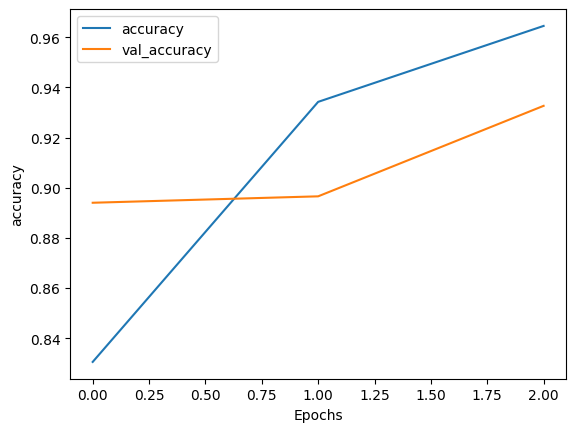

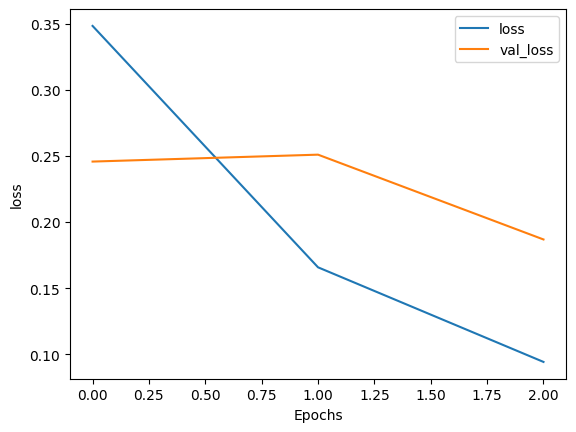

In [18]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

# Plot training results
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')